In [339]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocess

In [317]:
human_likert = pd.read_csv("results-likert-20231207.csv")
human_choice = pd.read_csv("results-choice-20231207.csv")

In [318]:
def match_sentences_across_dfs(source_df, reference_df):
    # only need certain columns from the reference df
    reference_df = reference_df.filter(items=['MetaTemplateID','TemplateID',
                                              'Target1','Target2',
                                              'Context1','Context2'])
    output_df = source_df.merge(reference_df, how='inner')
    return output_df

def preprocess_df(df, eval_type):
    """For free responses, leave the first numeric digit of the response"""
    if eval_type=="likert_free":
        for col in ["text_likert_target1_context1",
                   "text_likert_target2_context1",
                   "text_likert_target1_context2",
                   "text_likert_target2_context2"]:
            df[col] = df[col].apply(lambda s: re.sub("[^0-9.-]","",s))
            df[col] = df[col].apply(lambda s: s[0] if len(s)>1 else s)
            df[col] = pd.to_numeric(df[col], errors = 'coerce')
    elif eval_type=="choice_free":
        for col in ["text_choice_target1",
                   "text_choice_target2"]:
            df[col] = df[col].apply(lambda s: re.sub("[^0-9.-]","",s))
            df[col] = df[col].apply(lambda s: s[0] if len(s)>1 else s)
            df[col] = pd.to_numeric(df[col], errors = 'coerce')
    return df
        

def score_df(df, eval_type):
    if eval_type in ['likert_constrained', 'likert_free']:
        df['T1_response'] = df["text_likert_target1_context2"] - df["text_likert_target1_context1"]
        df['T2_response'] = df["text_likert_target2_context2"] - df["text_likert_target2_context1"]
    if eval_type in ['logprobs']:
        df['T1_response'] = df["logp_target1_context2"] - df["logp_target1_context1"]
        df['T2_response'] = df["logp_target2_context2"] - df["logp_target2_context1"]
    if eval_type in ['choice_constrained', 'choice_free']:
        df['T1_response'] = df["text_choice_target1"]
        df['T2_response'] = df["text_choice_target2"]
    return df


In [319]:
results_folder1 = os.path.join("../lm_outputs_20231204", "results")
lm_benchmarks1 = [ f.path for f in os.scandir(results_folder) if f.is_dir() ]
results_folder2 = os.path.join("../lm_outputs_20231206", "results")
lm_benchmarks2 = [ f.path for f in os.scandir(results_folder) if f.is_dir() ]

eval_types = ["logprobs", "likert_constrained", "choice_constrained"]
# eval_types = ["logprobs", "likert_free", "likert_constrained", 
#              "choice_free", "choice_constrained"]
models = ["gpt2_xl", "mpt_7b", "mpt_7b_chat", "mpt_30b", "mpt_30b_chat"]

all_results = dict()

for eval_type in eval_types:
    if eval_type in ["likert_constrained", "likert_free"]:
        lm_benchmarks = lm_benchmarks2
    else:
        lm_benchmarks = lm_benchmarks1
    all_results[eval_type] = dict()
    for model in models:
        df_list = []
        for b in lm_benchmarks:
            df = pd.read_csv(os.path.join(b, "eval=" + eval_type, "model=" + model, 
                                           "results-social_relations.csv"))
            df_list.append(df)
        df_full = match_sentences_across_dfs(pd.concat(df_list), human_likert)
        if eval_type in ["likert_free", "choice_free"]:
            df_full = preprocess_df(df_full, eval_type)
        df_full = score_df(df_full, eval_type)
        all_results[eval_type][model] = df_full.sort_values(by=["MetaTemplateID", "TemplateID"])

# add humans
all_results["likert_constrained"]["human"] = score_df(human_likert, 
                                                      "likert_constrained").sort_values(by=["MetaTemplateID", "TemplateID"])
all_results["choice_constrained"]["human"] = score_df(human_choice,
                                                      "choice_constrained").sort_values(by=["MetaTemplateID", "TemplateID"])

# Plot

In [321]:
def binarize_score(df, eval_type):
    """
    For choice:
    Takes the choice score and assigns 1 to values greater than 1.5 and -1 to the rest
    
    For Likert and logprobs:
    Takes the difference score and assigns 1 to values greater than 0 and -1 to the rest
    """
    
    if eval_type in ["choice_constrained", "choice_free"]:
        df["T1_response_binarized"] = [1 if x>1.5 else -1 for x in df["T1_response"] ]
        df["T2_response_binarized"] = [1 if x>1.5 else -1 for x in df["T2_response"] ]
    else:
        df["T1_response_binarized"] = [1 if x>0 else -1 for x in df["T1_response"] ]
        df["T2_response_binarized"] = [1 if x>0 else -1 for x in df["T2_response"] ]
    return df


### Sample

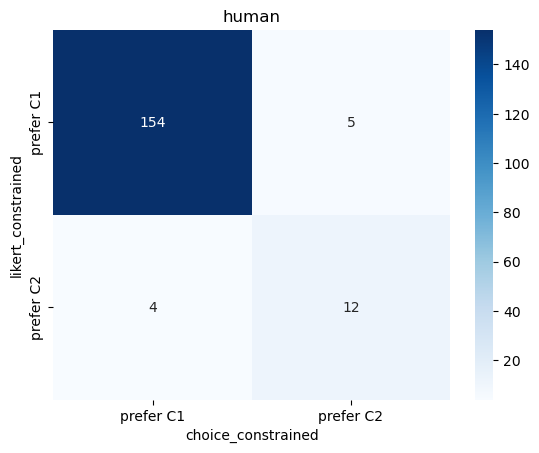

In [322]:
metric1 = "choice_constrained"
metric2 = "likert_constrained"
model = "human"

results1 = binarize_score(all_results[metric1][model], metric1)["T1_response_binarized"]
results2 = binarize_score(all_results[metric2][model], metric2)["T1_response_binarized"]


cm = confusion_matrix(
    results1,
    results2
)

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel(metric1)
plt.ylabel(metric2)
ax.set(
    xticklabels=["prefer C1", "prefer C2"],
    yticklabels=["prefer C1", "prefer C2"],
)
ax.set_title(model)
plt.show()

### Metric consistency within models and within humans

likert_constrained vs choice_constrained gpt2_xl: 0.54
logprobs vs likert_constrained gpt2_xl: 0.49
logprobs vs choice_constrained gpt2_xl: 0.48
likert_constrained vs choice_constrained mpt_7b: 0.83
logprobs vs likert_constrained mpt_7b: 0.51
logprobs vs choice_constrained mpt_7b: 0.49
likert_constrained vs choice_constrained mpt_7b_chat: 0.63
logprobs vs likert_constrained mpt_7b_chat: 0.52
logprobs vs choice_constrained mpt_7b_chat: 0.51
likert_constrained vs choice_constrained mpt_30b: 0.71
logprobs vs likert_constrained mpt_30b: 0.51
logprobs vs choice_constrained mpt_30b: 0.45
likert_constrained vs choice_constrained mpt_30b_chat: 0.74
logprobs vs likert_constrained mpt_30b_chat: 0.61
logprobs vs choice_constrained mpt_30b_chat: 0.49
likert_constrained vs choice_constrained human: 0.96


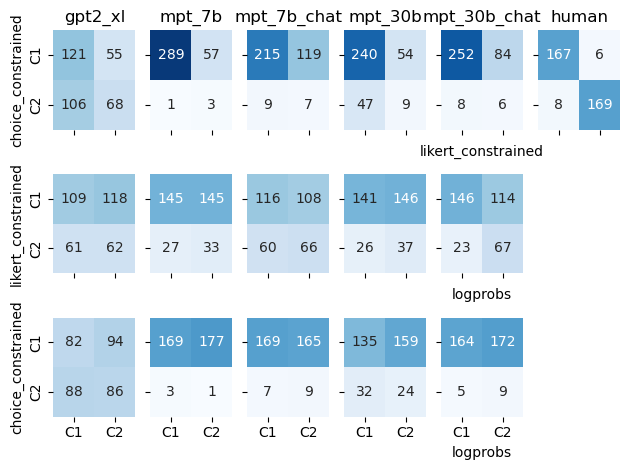

In [347]:
eval_pairs = [("likert_constrained", "choice_constrained"),
              ("logprobs", "likert_constrained"),
              ("logprobs", "choice_constrained")]


fig, axs = plt.subplots(len(eval_pairs), len(models)+1)

for m, model in enumerate(models + ["human"]):
    for e, eval_pair in enumerate(eval_pairs):
        if model=="human" and e>0:
            axs[e, m].set_axis_off()
            continue
        eval_type1 = eval_pair[0]
        eval_type2 = eval_pair[1]
        df1 = binarize_score(all_results[eval_type1][model], eval_type1)
        df2 = binarize_score(all_results[eval_type2][model], eval_type2)
        results1 = pd.concat([df1["T1_response_binarized"], df1["T2_response_binarized"]])
        results2 = pd.concat([df2["T1_response_binarized"], df2["T2_response_binarized"]])

        cm = confusion_matrix(
            results2,
            results1
        )
        # accuracy here should be the same as "matching score", a metric of similarity for 2 binary arrays
        print(eval_type1 + " vs " + eval_type2 + " " + model + ": " + \
              str(np.round(accuracy_score(results2, results1),2)))

        sns.heatmap(cm, ax=axs[e, m], annot=True, fmt="d", cmap="Blues", cbar=False, vmin=0, vmax=300)
        xtlab = []
        ytlab = []
        if m==0:
            axs[e, m].set_ylabel(eval_type2)
            ytlab = ["C1", "C2"]
        if m==len(models)-1:
            axs[e, m].set_xlabel(eval_type1)
        if e==len(eval_pairs)-1:
            
            xtlab = ["C1", "C2"]
        axs[e, m].set(
            xticklabels= xtlab,
            yticklabels= ytlab,
        )
        if e==0:
            axs[e,m].set_title(model)
            
fig.tight_layout()

### Model results compared to humans

choice_constrained gpt2_xl: 0.53
likert_constrained gpt2_xl: 0.5
logprobs gpt2_xl: 0.72
choice_constrained mpt_7b: 0.49
likert_constrained mpt_7b: 0.5
logprobs mpt_7b: 0.79
choice_constrained mpt_7b_chat: 0.5
likert_constrained mpt_7b_chat: 0.51
logprobs mpt_7b_chat: 0.82
choice_constrained mpt_30b: 0.49
likert_constrained mpt_30b: 0.51
logprobs mpt_30b: 0.81
choice_constrained mpt_30b_chat: 0.51
likert_constrained mpt_30b_chat: 0.64
logprobs mpt_30b_chat: 0.83
choice_constrained human: 1.0
likert_constrained human: 0.96


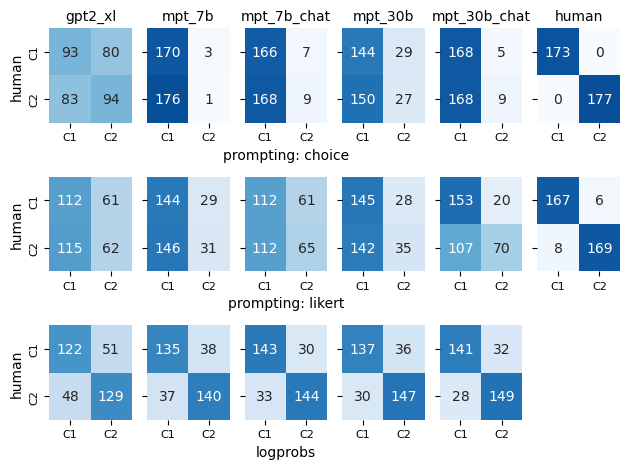

In [348]:
eval_types = ["choice_constrained", "likert_constrained", "logprobs"]

eval_labels = {
    "choice_constrained": "prompting: choice",
    "likert_constrained": "prompting: likert",
    "logprobs": "logprobs"
}

human_df = binarize_score(all_results["choice_constrained"]["human"], "choice_constrained")
human_scores = pd.concat([human_df["T1_response_binarized"], human_df["T2_response_binarized"]])

fig, axs = plt.subplots(len(eval_types), len(models)+1)

for m, model in enumerate(models + ["human"]):
    for e, eval_type in enumerate(eval_types):
        if model=="human" and e>1:
            axs[e, m].set_axis_off()
            continue
        df = binarize_score(all_results[eval_type][model], eval_type)
        results2 = pd.concat([df["T1_response_binarized"], df["T2_response_binarized"]])
        results1 = human_scores

        cm = confusion_matrix(
            results1,
            results2
        )
        print(eval_type + " " + model + ": " + str(np.round(accuracy_score(results1, results2),2)))

        sns.heatmap(cm, ax=axs[e, m], annot=True, fmt="d", cmap="Blues", cbar=False, vmin=0, vmax=200)
        xtlab = []
        ytlab = []
        if m==0:
            ytlab = ["C1", "C2"]
            axs[e, m].set_ylabel("human")
        if m==2:
            axs[e, m].set_xlabel(eval_labels[eval_type])
        #if e==len(eval_types)-1:
        xtlab = ["C1", "C2"]
        axs[e, m].set(
            xticklabels= xtlab,
            yticklabels= ytlab,
        )
        axs[e, m].xaxis.set_tick_params(labelsize=8)
        axs[e, m].yaxis.set_tick_params(labelsize=8)
        if e==0:
            axs[e,m].set_title(model, {'fontsize': 10})
            
fig.tight_layout()
plt.savefig("model-human_comparison.pdf")
plt.show()